# Intermediate Model - Deep Neural Network Reinforcement Learning

The baseline model will train an agent to manipulate two DMC's in series to maximize production. Instead of building a Q-table, the agent will learn a policy by neural networks.

In [6]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("tf.keras available:", hasattr(tf, "keras"))


TensorFlow version: 2.18.0
tf.keras available: True


In [7]:
from structure import DMC_structure
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from DMC_Env import DMC_Env

import logging
from datetime import datetime

from sac import SoftActorCritic
from replay_buffer import ReplayBuffer

tf.keras.backend.set_floatx('float64')

logging.basicConfig(level='INFO')


As per the format explained above, the DMC chain is initialized below.

In [8]:
DMCarr = [[] for i in [0, 1]]
            # index, next, func, goal, input (T, P, Keq)
DMCarr[0] = [0, [0, 1], "DMC1", 400, [350, 5, 1]]
DMCarr[1] = [1, [], "DMC2", 500, [350, 5, 1]]
# DMCarr[2] = [2, [], "Dummy", 0, [0, 0, 0]]

print("DMC array:", DMCarr)
struct = DMC_structure(DMCarr)

DMC array: [[0, [0, 1], 'DMC1', 400, [350, 5, 1]], [1, [], 'DMC2', 500, [350, 5, 1]]]


Enviornment Setup

In [10]:
args = {
    'seed': 42,
    'render': False,
    'verbose': False,
    'batch_size': 128,
    'epochs': 50,
    'start_steps': 0,
    'model_path': '../data/models/',
    'model_name': f'{str(datetime.utcnow().date())}-{str(datetime.utcnow().time())}',
    'gamma': 0.99,
    'polyak': 0.995,
    'learning_rate': 0.001,
}



In [14]:
# Define DMC environment setup
DMCarr = [
    [0, [1], "DMC1", 400, [350, 5, 1]],  # DMC 0
    [1, [], "DMC2", 500, [360, 4, 2]]    # DMC 1
]
env = DMC_Env(DMCarr)

state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]

replay = ReplayBuffer(state_space, action_space)

log_dir = args['model_path'] + '/logs/' + datetime.utcnow().strftime("%Y%m%d-%H%M%S")
writer = tf.summary.create_file_writer(log_dir)

sac = SoftActorCritic(action_space, writer,
                      learning_rate=args['learning_rate'],
                      gamma=args['gamma'],
                      polyak=args['polyak'])



In [ ]:
n = 10 #of episodes to run


In [18]:
episode_rewards = []
global_step = 0
episode = 0
prev_avg_episode_reward = None

# Run for n episodes
for _ in range(n):
    current_state = env.reset()
    step = 1
    episode_reward = 0
    done = False

    while not done:
        if args['render']:
            env.render()

        # Choose action: use fully random action during exploration phase.
        if global_step < args['start_steps']:
            action = env.action_space.sample()
        else:
            action = sac.sample_action(current_state)
            # In case the action is still a scalar, force it into an array.
            if np.isscalar(action):
                action = np.array([action])

        # Step in the environment.
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        end = 0 if done else 1

        # Optional logging per step.
        if args.get('verbose', False):
            logging.info(f"Global step: {global_step}")
            logging.info(f"Current state: {current_state}")
            logging.info(f"Action: {action}")
            logging.info(f"Reward: {reward}")
            logging.info(f"Next state: {next_state}")
            logging.info(f"End flag: {end}")

        # Store the transition in replay buffer.
        replay.store(current_state, action, reward, next_state, end)

        current_state = next_state
        step += 1
        global_step += 1

    # Training: only if enough samples are available and the exploration phase is over.
    if replay.total_size > args['batch_size'] and global_step > args['start_steps']:
        for epoch in range(args['epochs']):
            current_states, actions, rewards, next_states, ends = replay.fetch_sample(num_samples=args['batch_size'])
            critic1_loss, critic2_loss, actor_loss, alpha_loss = sac.train(
                current_states, actions, rewards, next_states, ends
            )

            if args.get('verbose', False):
                print(f"Episode {episode}, Global step {global_step}, Epoch {epoch}:",
                      critic1_loss.numpy(), critic2_loss.numpy(),
                      actor_loss.numpy(), f"Episode Reward: {episode_reward}")

            # Increase the training epoch step and update target networks each epoch.
            sac.epoch_step += 1
            sac.update_weights()  # Now uses assign() inside the SAC module.

    # Save model every 100 episodes (adjustable as needed).
    if episode % 100 == 0:
        sac.policy.save_weights(args['model_path'] + args['model_name'] + '/model')

    # Update reward history and compute the average over the last 100 episodes.
    episode_rewards.append(episode_reward)
    episode += 1
    avg_episode_reward = sum(episode_rewards[-100:]) / len(episode_rewards[-100:])

    # Print the reward and average.
    print(f"Episode {episode} reward: {episode_reward}")
    print(f"Episode {episode} Average episode reward: {avg_episode_reward}")

    # Calculate and print the change in average reward compared to the previous episode.
    if prev_avg_episode_reward is not None:
        change = avg_episode_reward - prev_avg_episode_reward
        print(f"Change in average reward: {change}")
    prev_avg_episode_reward = avg_episode_reward


TypeError: 'int' object does not support item assignment

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 752.6141 - mae: 19.1895 - val_loss: 32.7351 - val_mae: 5.0895
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28.4605 - mae: 4.4132 - val_loss: 13.0947 - val_mae: 2.9001
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13.4980 - mae: 3.0481 - val_loss: 10.8092 - val_mae: 2.5964
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.4383 - mae: 2.7555 - val_loss: 10.4366 - val_mae: 2.6705
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 11.4238 - mae: 2.7279 - val_loss: 10.8499 - val_mae: 2.7067
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.3429 - mae: 2.6132 - val_loss: 9.1766 - val_mae: 2.4530
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.4239 - mae: 2.6433 - val_loss: 8.8842 - val_mae: 2.3881
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.4613 - mae: 2.5974 - val_loss: 16.6994 - val_mae: 3.3258
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0

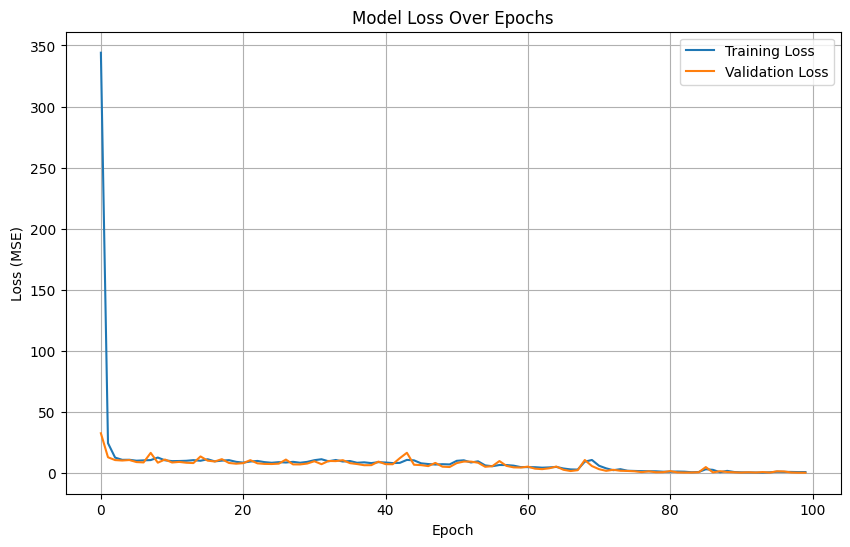

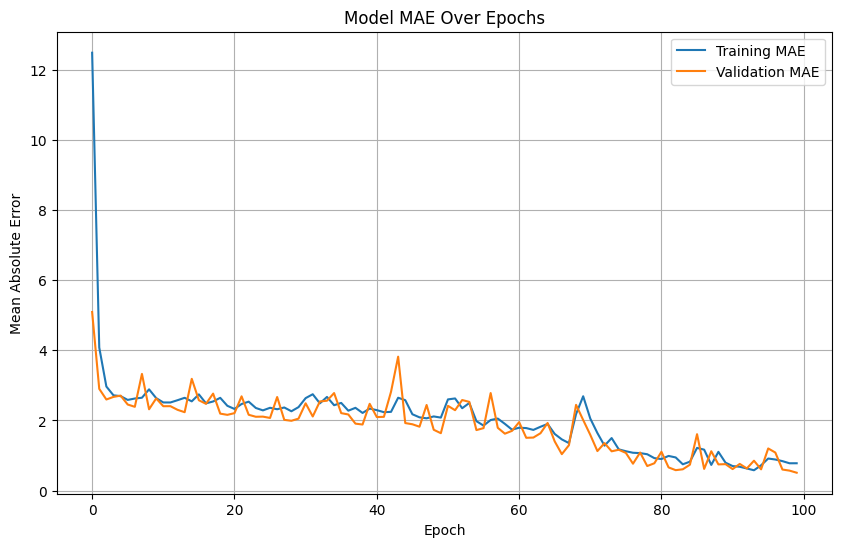

Final Validation Loss (MSE): 0.4619
Final Validation MAE: 0.5096


In [ ]:
history = simple_train_model(epochs=100, batch_size=32)

running the optimal value search:

In [ ]:
optimal_dmc, optimal_reward = find_optimal_dmc(DMCarr, bounds)
print("Optimal DMC values:", optimal_dmc)
print("Predicted optimal reward:", optimal_reward)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━

## Discussion

The program predicted that the optimal DMC set temperatures should be 897 degrees and 995 degrees. We have found that this solution is not stable, and that previous iterations have predicted other temperatures such as 500 degrees and 998 degrees. Given that our bounds are (250, 500) and (400, 600), the reward function needs more tuning in order to stay within the bounds of our system and provide a stable solution. We tried different combinations of functions, and did not get a satisfactory result - we may write a continous rather than a linear reward function to address this.

In regards to the training, the final MSE and MAE values are relatively low and stable, indicating that the model has learned a reasonable mapping from goals (inputs) to rewards (outputs).
The small gap between training and validation suggests that the model is generalizing well rather than just memorizing the training data. Monitoring both MSE and MAE provides a more complete picture of performance: MSE helps drive the training optimization, and MAE offers a straightforward “average error” interpretation.

## Summary:

1. The goal is to have an agent control multiple DMC's within a complex process to maximize some value through reinforcement learning
2. Each DMC takes in some start conditions and attempts to optimize them within their own controls, like a PID controller for temperature. The agent only changes the goal, not the behavior itself.
3. The agent wants to maximize a reward, which is a balance between increasing $K_{eq}$ as much as possible, and staying within constraints.

For the baseline model:
1. The process is two DMC's in series.
2. The reward is based on a linear positive reward for $K_{eq}$ and a fixed negative reward for each violation of bounds
3. The exploration is a naive approach of generating data at random points, from fixed start conditions.
4. Due to the naive approach, the training basically becomes supervised learning of finding rewards given our exploration batch.
5. Due to the naive approach, finding the optimal value becomes a search through the supervised model.

We found:
1. The model trained and generalized well
2. We need to adjust our reward function

In the future we hope to:
1. Optimize a far more complex process, with many more DMC's in parallel and in series, with more random fluctuations.
2. Have a more sophisiticated and balanced reward function.
3. Do an exploration based on seeking a better reward rather than the naive approach.
4. Transition from Naive learning to Q-learning, then to more advanced RL algorithms.
